In [1]:
!pip install --upgrade seaborn # just want some nice plots! (update seaborn to use newest version)

     |████████████████████████████████| 283 kB 1.3 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import re

Here is our data below:

In [3]:
humor_oneliners = pd.read_pickle("../input/humor-detection/Short-Text-Corpus-For-Humor-Detection-master/Short-Text-Corpus-For-Humor-Detection-master/datasets/humorous_oneliners.pickle")
double_oneliners = pd.read_pickle("../input/humor-detection/Short-Text-Corpus-For-Humor-Detection-master/Short-Text-Corpus-For-Humor-Detection-master/datasets/oneliners_incl_doubles.pickle")
proverbs = pd.read_pickle("../input/humor-detection/Short-Text-Corpus-For-Humor-Detection-master/Short-Text-Corpus-For-Humor-Detection-master/datasets/proverbs.pickle")
headlines = pd.read_pickle("../input/humor-detection/Short-Text-Corpus-For-Humor-Detection-master/Short-Text-Corpus-For-Humor-Detection-master/datasets/reuters_headlines.pickle")
wiki = pd.read_pickle("../input/humor-detection/Short-Text-Corpus-For-Humor-Detection-master/Short-Text-Corpus-For-Humor-Detection-master/datasets/wiki_sentences.pickle")

jokes = humor_oneliners+double_oneliners
non_jokes = proverbs+headlines+wiki
dataset = humor_oneliners+double_oneliners+proverbs+headlines+wiki
data = pd.DataFrame({"Sequence":dataset,
                     "Sequence Type":["Joke" if sequence in jokes else "Non-Joke" for sequence in dataset]})
data

,Sequence,Sequence Type
0,"Insanity is hereditary, - You get it from your...",Joke
1,"An honest politician is one who, when bought, ...",Joke
2,"You can tune a piano, but you can't tuna fish.",Joke
3,A closed mouth gathers no foot.,Joke
4,What's black and white and red all over? An e...,Joke
...,...,...
22175,"He got some jobs in Asbury Park , New Jersey ,...",Non-Joke
22176,It is the ninth game in the original Mega Man ...,Non-Joke
22177,"The name is short for Shenjiang Xinbao , Shenj...",Non-Joke
22178,"Of the two albatross species found in Hawaii ,...",Non-Joke


We will repeat our data cleaning steps from earlier here to offer better analysis. Also, we will do extra cleaning steps like removing stop words and punctuation so we can take a closer look at certain features like most common words and phrases bought up.

In [4]:
def lemmatize(s):
    wordnet_lemmatizer = WordNetLemmatizer()
    return " ".join([wordnet_lemmatizer.lemmatize(w,'v') for w in s.split(" ")])
def lower(s):
    return s.lower()
def remove_stop_words(s):
    return " ".join([w for w in s.split(" ") if not w in stopwords.words("english")])
def clean(data, include_stop_words=False):
    cleaned = []
    for item in data:
        item = re.sub("[.!?\\-,\'\"]", "", item) # remove punctuation (the [] defines a set of characters for to look for)
        item = item.lower()
        item = lemmatize(item)
        item = re.sub(r'\d+', '', item) # remove nums
        if not include_stop_words:
            item = remove_stop_words(item)
        item = re.sub(" +", " ", item) # removes extra spaces from cleaning (the + selects multiple occurrences of the space)
        cleaned.append(item)
    return cleaned

In [5]:
cleaned = clean(data["Sequence"])
cleaned_no_stop = clean(data["Sequence"], include_stop_words=True)
data["Cleaned Sequence"] = cleaned
data["Cleaned Sequence w/ Stop Words"] = cleaned_no_stop
data

,Sequence,Sequence Type,Cleaned Sequence,Cleaned Sequence w/ Stop Words
0,"Insanity is hereditary, - You get it from your...",Joke,insanity hereditary get children,insanity be hereditary you get it from your ch...
1,"An honest politician is one who, when bought, ...",Joke,honest politician one buy stay buy,an honest politician be one who when buy stay buy
2,"You can tune a piano, but you can't tuna fish.",Joke,tune piano cant tuna fish,you can tune a piano but you cant tuna fish
3,A closed mouth gathers no foot.,Joke,close mouth gather foot,a close mouth gather no foot
4,What's black and white and red all over? An e...,Joke,whats black white red embarassed zebra,whats black and white and red all over an emba...
...,...,...,...,...
22175,"He got some jobs in Asbury Park , New Jersey ,...",Non-Joke,get job asbury park new jersey play hongkong i...,he get some job in asbury park new jersey play...
22176,It is the ninth game in the original Mega Man ...,Non-Joke,ninth game original mega man series first seri...,it be the ninth game in the original mega man ...
22177,"The name is short for Shenjiang Xinbao , Shenj...",Non-Joke,name short shenjiang xinbao shenjiang short fo...,the name be short for shenjiang xinbao shenjia...
22178,"Of the two albatross species found in Hawaii ,...",Non-Joke,two albatross species find hawaii one blackfoo...,of the two albatross species find in hawaii on...


Let's first take a look at the phrase length, and if there is any significant difference in their distributions.

In [6]:
data["Sequence Length"] = [len(sequence) for sequence in data["Cleaned Sequence"]]
data["Cleaned Sequence Length"] = [len(sequence) for sequence in data["Cleaned Sequence"]]
data["Sequence Word Count"] = [len(sequence.split(" ")) for sequence in data["Cleaned Sequence"]]

Text(0.5, 1.0, 'Length of Input Sequence for Jokes vs Non-Jokes')

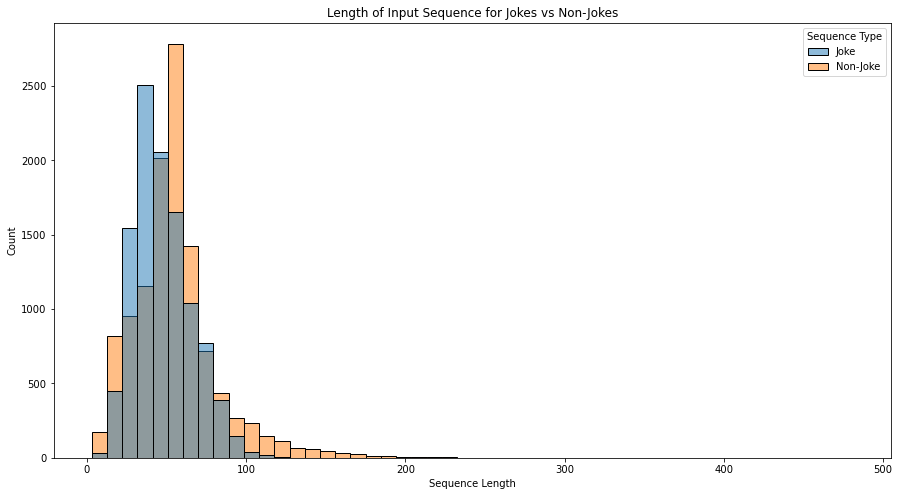

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(ax=ax, data=data, x="Sequence Length", hue="Sequence Type", bins=50)
ax.set_title("Length of Input Sequence for Jokes vs Non-Jokes")

The immediately clear conclusion from the plot above is the the level of right-skew on the distributions of jokes and non-jokes. Most of them are about 0-200 characters in length, but some of them are much larger. Comparatively, these values are not as common, since they are not even visible as bars on the histogram (especially near the right end of the graph). These later values are more likely outliers with respect to sequence length.

In [8]:
by_type = data.groupby("Sequence Type")
print(by_type["Sequence Length"].size())

Sequence Type
Joke        10667
Non-Joke    11513
Name: Sequence Length, dtype: int64


In [9]:
by_type["Sequence Length"].median()

Sequence Type
Joke        45
Non-Joke    53
Name: Sequence Length, dtype: int64

The median of each distribution confirms that both distributions are centered at around the same region, at about 40-50 characters (this is cleaned data, so there counts only the most important words and excludes punctuation and numbers). Of note, the median length of Joke Sequences is less than the median length of Non-Joke Sequences.

In [10]:
f_quart = by_type["Sequence Length"].quantile(.25)
t_quart = by_type["Sequence Length"].quantile(.75)
print("First Quartile: Joke - %d Characters, Non-Jokes - %d Characters" % (f_quart[0], f_quart[1]))
print("Third Quartile: Joke - %d Characters, Non-Jokes - %d Characters" % (t_quart[0], t_quart[1]))
print("IQR: Joke- %d Characters, Non-Jokes - %d Characters" % (t_quart[0] - f_quart[0],t_quart[1] - f_quart[1]))

First Quartile: Joke - 34 Characters, Non-Jokes - 40 Characters
Third Quartile: Joke - 59 Characters, Non-Jokes - 64 Characters
IQR: Joke- 25 Characters, Non-Jokes - 24 Characters


Of interest, the spread of the values for the length of Non-Joke Sequences (IQR of 25) is about the same as those for Joke Sequences (IQR of 24). This suggests that when it comes down to the most important information regarding the statement, length wise, the variance in the word lengths is about the same.

While mean and standard deviation are more susceptible to skew, they still tell a similar story to that found above, reaffirming the results. Notably though, the standard deviation for the amount of characters for a non-joke sequence is much greater than for a joke sequence, different from our results considering IQR. This is probably because of the skew, as seen in larger tail on the distribution of non-joke character counts.

In [11]:
mean = by_type["Sequence Length"].mean()
std = by_type["Sequence Length"].std()
print("Mean: Joke - %d Characters, Non-Jokes - %d Characters" % (mean[0], mean[1]))
print("Standard Deviation: Joke - %d Characters, Non-Jokes - %d Characters" % (std[0], std[1]))

Mean: Joke - 47 Characters, Non-Jokes - 55 Characters
Standard Deviation: Joke - 18 Characters, Non-Jokes - 27 Characters


We can take a look at this in comparison to number of words per sequences, and see there are any noticeable differences between word count and character count.

Text(0.5, 1.0, 'Number of Words for Jokes vs Non-Jokes')

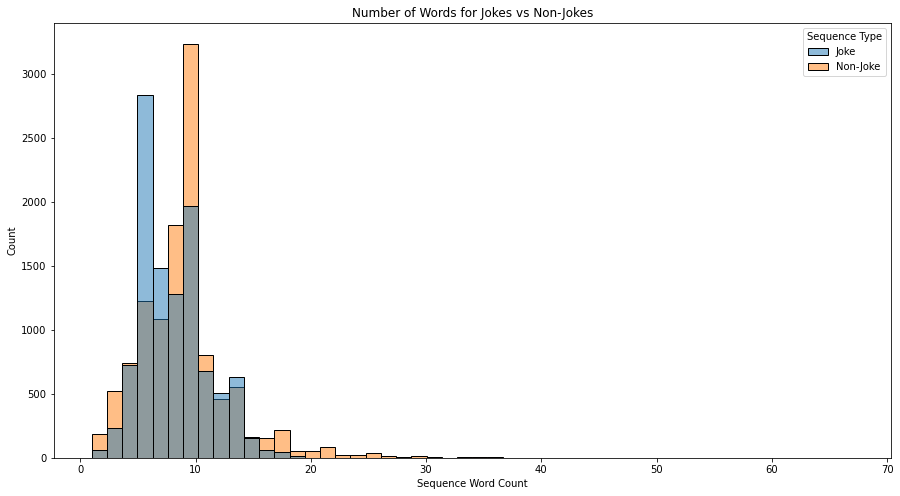

In [12]:
fig, ax2 = plt.subplots(figsize=(15,8))
sns.histplot(ax=ax2, data=data, x="Sequence Word Count", hue="Sequence Type", bins=50)
ax2.set_title("Number of Words for Jokes vs Non-Jokes")

Interestingly here, there is seems to be a greater spread in the word count for jokes than for non-jokes, but about the same center point for the distribution. Lets confirm this numerically.

In [13]:
by_type["Sequence Word Count"].median()

Sequence Type
Joke        8
Non-Joke    9
Name: Sequence Word Count, dtype: int64

There is a small difference in the average number of words in a joke and in a non-joke, with Non-Joke Sequences having more words. This corresponds with our findings with respect to character count, where since there are more words, there are also more characters.

In [14]:
f_quart_word = by_type["Sequence Word Count"].quantile(.25)
t_quart_word = by_type["Sequence Word Count"].quantile(.75)
print("First Quartile: Joke - %d Words, Non-Jokes - %d Words" % (f_quart_word[0], f_quart_word[1]))
print("Third Quartile: Joke - %d Words, Non-Jokes - %d Words" % (t_quart_word[0], t_quart_word[1]))
print("IQR: Joke- %d Words, Non-Jokes - %d Words" % (t_quart_word[0] - f_quart_word[0],t_quart_word[1] - f_quart_word[1]))

First Quartile: Joke - 6 Words, Non-Jokes - 7 Words
Third Quartile: Joke - 10 Words, Non-Jokes - 10 Words
IQR: Joke- 4 Words, Non-Jokes - 3 Words


There is a small difference in spread, showing that the spread in the distribution of word count for a Joke Sequence is a little greater than for a Non-Joke Sequences, suggesting that the jokes in this dataset tend to vary a little more in size.

Looking at the mean and standard deviation, we see that the measures of center agree on which distribution has a lower center, but there are differing results for spread. The distribution of word counts for Non-Joke Sequences has a larger standard deviation, but smaller interquartile range than the distribution of word counts for Joke Sequences. This is a result of skew, which is why we first presented the IQR, since it is more resistant to skew than standard deviation.

In [15]:
mean_word = by_type["Sequence Word Count"].mean()
std_word = by_type["Sequence Word Count"].std()
print("Mean: Joke - %d Words, Non-Jokes - %d Words" % (mean_word[0], mean_word[1]))
print("Standard Deviation: Joke - %d Words, Non-Jokes - %d Words" % (std_word[0], std_word[1]))

Mean: Joke - 7 Words, Non-Jokes - 8 Words
Standard Deviation: Joke - 3 Words, Non-Jokes - 4 Words


In general though, it seems our results for word count do agree with our results for character count, which is to be expected.

Another interesting feature to take a look at in a similar vein is the mean length of words.

In [16]:
def mean_word_length(sequence):
    means = np.array([len(word) for word in sequence.split(" ")])
    return means.mean()

data["Sequence Mean Word Length"] = [mean_word_length(sequence) for sequence in data["Cleaned Sequence"]]

Text(0.5, 1.0, 'Mean Length of Words for Jokes vs Non-Jokes')

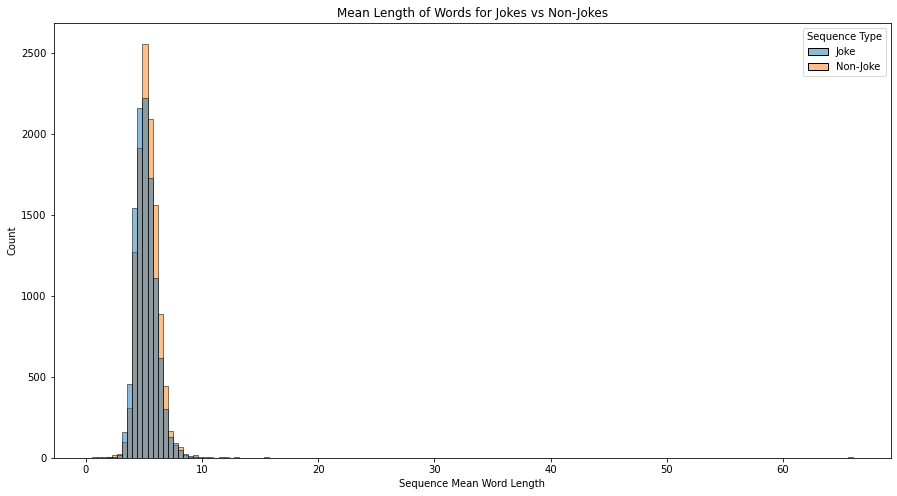

In [17]:
fig, ax3 = plt.subplots(figsize=(15,8))
sns.histplot(ax=ax3, data=data, x="Sequence Mean Word Length", hue="Sequence Type", bins=150)
ax3.set_title("Mean Length of Words for Jokes vs Non-Jokes")

From an initial glance, there is a minimal difference in the distributions of average count for jokes and non-jokes. We'll then take a look at the center and spread to better grasp what is going on.

In [18]:
median_word_length = by_type["Sequence Mean Word Length"].median()
median_word_length

Sequence Type
Joke        5.000000
Non-Joke    5.222222
Name: Sequence Mean Word Length, dtype: float64

This means that basically, the length of words used in jokes versus those in non-jokes are very similar, suggesting that the level of vocabulary for each of these types of phrases are about the same (assuming there is a positive correlation between level of vocabulary and word length).  

In [19]:
f_quart_length = by_type["Sequence Mean Word Length"].quantile(.25)
t_quart_length = by_type["Sequence Mean Word Length"].quantile(.75)
print("First Quartile: Joke - %d Characters, Non-Jokes - %d Characters" % (f_quart_length[0], f_quart_length[1]))
print("Third Quartile: Joke - %d Characters, Non-Jokes - %d Characters" % (t_quart_length[0], t_quart_length[1]))
print("IQR: Joke- %d Characters, Non-Jokes - %d Characters" % (t_quart_length[0] - f_quart_length[0],t_quart_length[1] - f_quart_length[1]))

First Quartile: Joke - 4 Characters, Non-Jokes - 4 Characters
Third Quartile: Joke - 5 Characters, Non-Jokes - 5 Characters
IQR: Joke- 1 Characters, Non-Jokes - 1 Characters


These distributions also have the same IQR, meaning they vary from the measure of center in similar ways on average. All this suggests that there little different in the distributions of average word length for Joke sequences and Non-Joke Sequences.

Switching gears, lets take a look at the most common (non-stopword) words in each set of data, and see if there are any patterns.

In [20]:
def word_frequency(data):
    frequency = {}
    for seq in data:
        for word in seq.split(" "):
            if word in frequency:
                frequency[word] += 1
            else:
                frequency[word] = 1
    return frequency
frequency_joke = word_frequency(data.loc[data["Sequence Type"]=="Joke"]["Cleaned Sequence"])
frequency_non_joke = word_frequency(data.loc[data["Sequence Type"]=="Non-Joke"]["Cleaned Sequence"])

Text(0.5, 1.0, 'Most Common Words in Non-Joke Sequences')

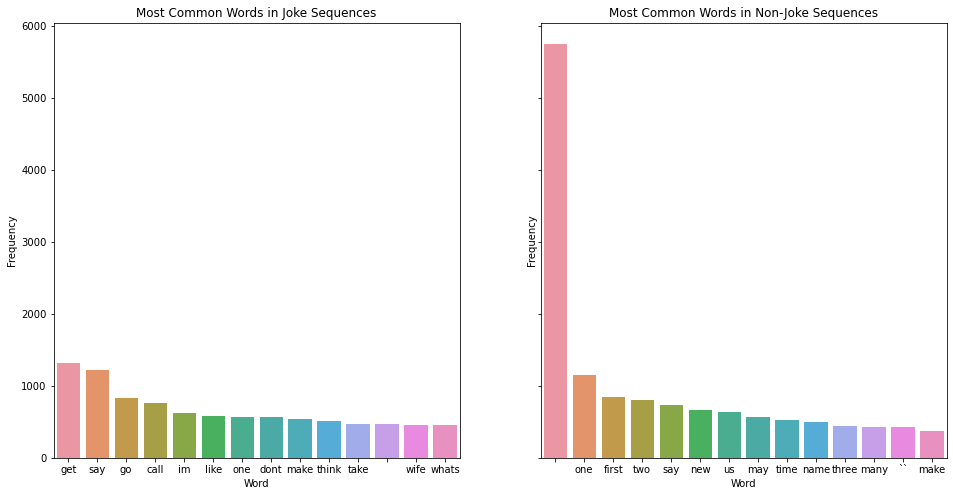

In [21]:
slc_start = 0
slc_end = slc_start+14

joke_freq = dict(sorted(frequency_joke.items(), key=lambda item: item[1], reverse=True))
non_joke_freq = dict(sorted(frequency_non_joke.items(), key=lambda item: item[1], reverse=True))
df_joke = pd.DataFrame({"Word":joke_freq.keys(), "Frequency":joke_freq.values()})
df_non_joke = pd.DataFrame({"Word":non_joke_freq.keys(), "Frequency":non_joke_freq.values()})
fig, ax = plt.subplots(1,2, sharey=True, figsize=(16,8))
sns.barplot(ax=ax[0], data=df_joke[slc_start:slc_end], x="Word", y="Frequency")
ax[0].set_title("Most Common Words in Joke Sequences")
sns.barplot(ax=ax[1], data=df_non_joke[slc_start:slc_end], x="Word", y="Frequency")
ax[1].set_title("Most Common Words in Non-Joke Sequences")

An interesting observation to make here is how the empty string is the most common "word" for non-joke sequences. These empty strings are a result of data cleaning (removing punctuation and digits). This may suggest that jokes have much less punctuation/numbers relative to non-jokes, especially since there are about the same amount of jokes and non-jokes (10667 jokes vs 11515 non-jokes).

Another difference is the higher frequency of action oriented words in jokes versus in non-jokes. Words like "call", "go", "make", "take", "think", "get" are of higher frequency for jokes. Meanwhile for non-jokes, there appear to be nouns and pronouns like "us", "time", "new", "two", "may". From that, there may be evidence to suggest that jokes more commonly utilize actions to create humor, more so than a non-joke does.

Let us then consider what stop words are most commonly used in our data, as opposed to the more important words.

In [22]:
def stop_word_frequency(data):
    frequency = {}
    for seq in data:
        for word in seq.split(" "):
            if word in stopwords.words("english"):
                if word in frequency:
                    frequency[word] += 1
                else:
                    frequency[word] = 1
    return frequency
stop_frequency_joke = stop_word_frequency(data.loc[data["Sequence Type"]=="Joke"]["Cleaned Sequence w/ Stop Words"])
stop_frequency_non_joke = stop_word_frequency(data.loc[data["Sequence Type"]=="Non-Joke"]["Cleaned Sequence w/ Stop Words"])
stop_joke_freq = dict(sorted(stop_frequency_joke.items(), key=lambda item: item[1], reverse=True))
stop_non_joke_freq = dict(sorted(stop_frequency_non_joke.items(), key=lambda item: item[1], reverse=True))
df_stop_joke = pd.DataFrame({"Word":stop_joke_freq.keys(), "Frequency":stop_joke_freq.values()})
df_stop_non_joke = pd.DataFrame({"Word":stop_non_joke_freq.keys(), "Frequency":stop_non_joke_freq.values()})

Text(0.5, 1.0, 'Most Common Stop Words in Non-Joke Sequences')

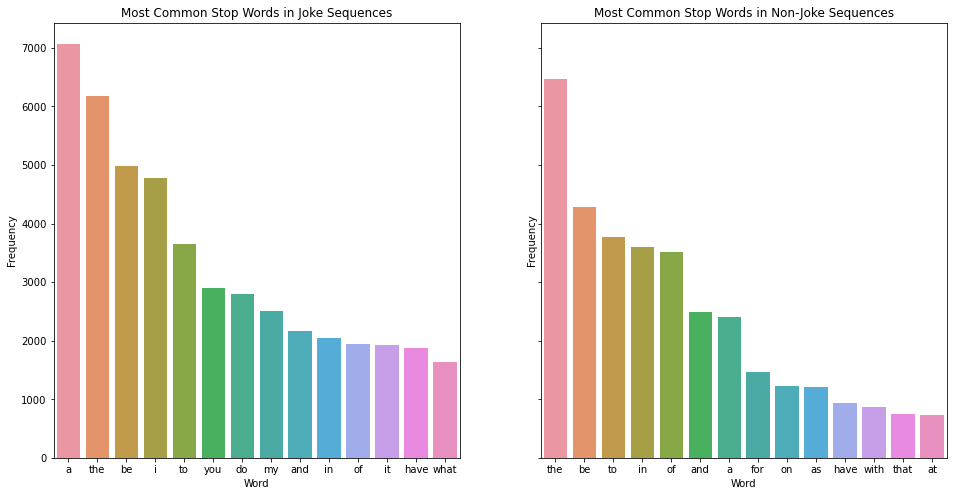

In [23]:
fig, ax5 = plt.subplots(1,2, sharey=True, figsize=(16,8))
sns.barplot(ax=ax5[0], data=df_stop_joke[slc_start:slc_end], x="Word", y="Frequency")
ax5[0].set_title("Most Common Stop Words in Joke Sequences")
sns.barplot(ax=ax5[1], data=df_stop_non_joke[slc_start:slc_end], x="Word", y="Frequency")
ax5[1].set_title("Most Common Stop Words in Non-Joke Sequences")

While most of the words here are the same, one interesting feature of note is how "i" is much more common for Jokes than for Non-Jokes. This suggests that the jokes in our dataset more often utilize the first person than the non-jokes. Another intersting observation is the use of "a" much more frequently in jokes than in non-jokes. This may suggests jokes in our dataset utilize the usage of some variable noun construct rather than a definite one (which would require the use of "the") to precede it. 